
We start by importing the standard libraries that we will need:

In [2]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Now we can read in the whole file in one line. I have edited the SCAN_NAME to be in a format that pandas can directly interpret as a date-time variable and I have told read_csv which field it is and to use it as the index of the dataframe.
In Jupyter, you can just type the pandas dataframe name and get a useful overview of the columns and the first and last scans.

In [3]:
WindData=pd.read_csv('wind_stats-readable_dt.csv',parse_dates=['SCAN_NAME'],index_col='SCAN_NAME')
WindData

,ws62,stdev62,wd60
SCAN_NAME,,,
2011-01-01 00:00:00,3.65,0.18,255.43
2011-01-01 00:10:00,3.79,0.15,260.83
2011-01-01 00:20:00,3.74,0.17,260.23
2011-01-01 00:30:00,3.25,0.21,269.83
2011-01-01 00:40:00,3.03,0.25,271.83
...,...,...,...
2011-12-31 23:10:00,6.26,0.70,165.93
2011-12-31 23:20:00,6.39,0.59,165.63
2011-12-31 23:30:00,6.79,0.61,167.43



Pandas lets us make new columns that are derived from some of the other columns of the dataframe. Here we make a turbulence intensity (TI) that is simply the wind speed standard deviation divided by the mean and multiplied by 100 to give it in percent.

In [4]:
WindData['TI']=WindData['stdev62']/WindData['ws62']*100
WindData

,ws62,stdev62,wd60,TI
SCAN_NAME,,,,
2011-01-01 00:00:00,3.65,0.18,255.43,4.931507
2011-01-01 00:10:00,3.79,0.15,260.83,3.957784
2011-01-01 00:20:00,3.74,0.17,260.23,4.545455
2011-01-01 00:30:00,3.25,0.21,269.83,6.461538
2011-01-01 00:40:00,3.03,0.25,271.83,8.250825
...,...,...,...,...
2011-12-31 23:10:00,6.26,0.70,165.93,11.182109
2011-12-31 23:20:00,6.39,0.59,165.63,9.233177
2011-12-31 23:30:00,6.79,0.61,167.43,8.983800


Pandas also has a describe() method that gives stats of all the fields:

In [5]:
WindData.describe()

,ws62,stdev62,wd60,TI
count,52560.000000,52560.000000,52560.000000,52560.000000
mean,6.115011,0.628923,175.825087,13.074100
std,3.717117,0.349155,76.455721,8.991359
min,0.240000,0.000000,0.030000,0.000000
25%,3.110000,0.350000,144.230000,7.767756
50%,5.500000,0.560000,177.430000,10.600353
75%,8.460000,0.850000,222.830000,15.344254
max,22.530000,3.850000,359.980000,94.736842


Its very easy to plot the variables in a dataframe. Because we have told pandas that the index is date-time, the plots will be true time series. Here I have made 4 sub-plots:

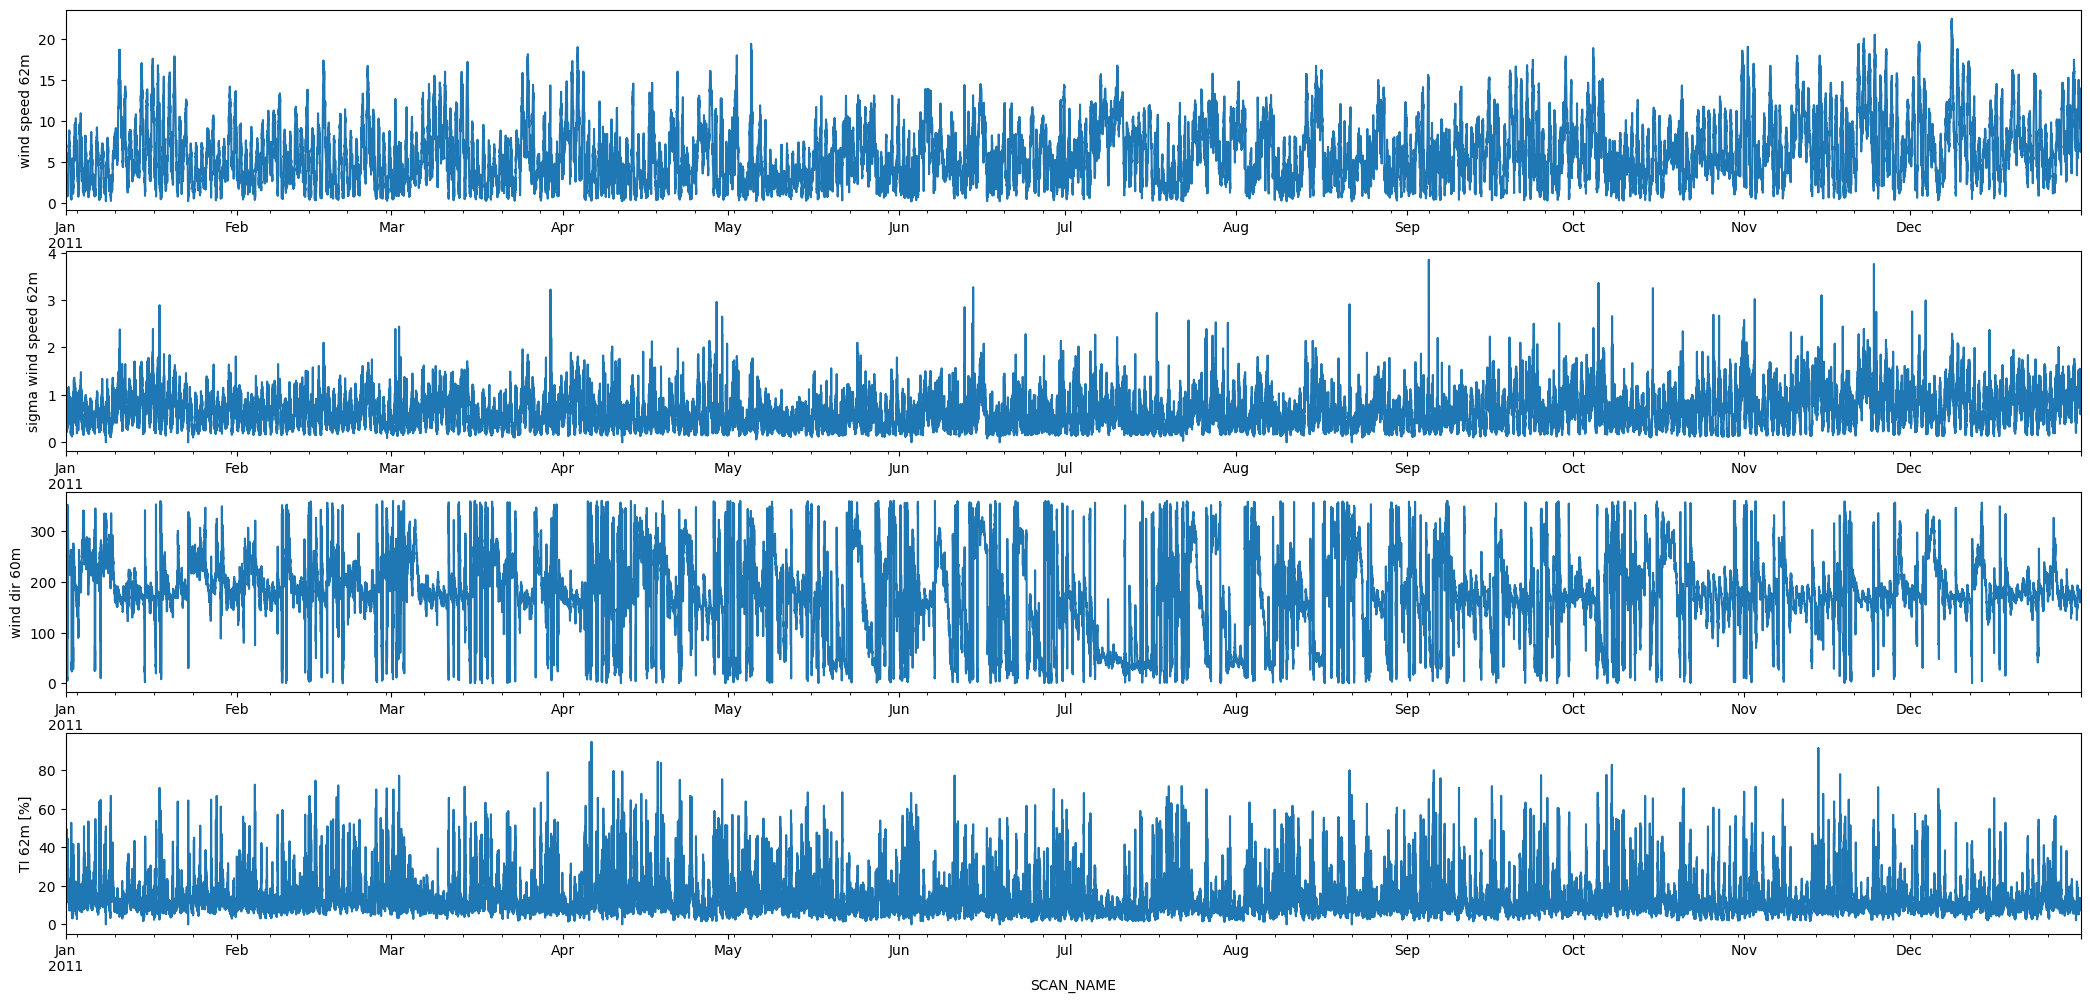

In [6]:
fig = plt.figure(figsize=(26, 12))
ax1=fig.add_subplot(411)
WindData['ws62'].plot(ax=ax1,ylabel="wind speed 62m")

ax2=fig.add_subplot(412)
WindData['stdev62'].plot(ax=ax2,ylabel="sigma wind speed 62m")

ax3=fig.add_subplot(413)
WindData['wd60'].plot(ax=ax3,ylabel="wind dir 60m")

ax4=fig.add_subplot(414)
WindData['TI'].plot(ax=ax4,ylabel='TI 62m [%]')

plt.show()


Making statistics on columns is this easy:

In [7]:
print('Total samples: {}, Mean speed:{:5.2f} m/s, Mean TI:{:5.1f} %'.format(WindData['ws62'].count(),WindData['ws62'].mean(), WindData['TI'].mean()))

Total samples: 52560, Mean speed: 6.12 m/s, Mean TI: 13.1 %


We very often need to analyse wind data in bins (ranges) of wind speed and wind direction. Here we make a simple wind speed bin (its just the integer part of the speed) as a new column in the data frame. We will use it a bit later.

In [8]:
WindData['speed_bin']=np.floor(WindData['ws62']).astype(int)
WindData

,ws62,stdev62,wd60,TI,speed_bin
SCAN_NAME,,,,,
2011-01-01 00:00:00,3.65,0.18,255.43,4.931507,3
2011-01-01 00:10:00,3.79,0.15,260.83,3.957784,3
2011-01-01 00:20:00,3.74,0.17,260.23,4.545455,3
2011-01-01 00:30:00,3.25,0.21,269.83,6.461538,3
2011-01-01 00:40:00,3.03,0.25,271.83,8.250825,3
...,...,...,...,...,...
2011-12-31 23:10:00,6.26,0.70,165.93,11.182109,6
2011-12-31 23:20:00,6.39,0.59,165.63,9.233177,6
2011-12-31 23:30:00,6.79,0.61,167.43,8.983800,6


We need a direction bin with a width of 30 degrees but centred +-15 degrees on either side of the nominal value. Directions are often difficult because of the 0-360-0 numeric discontinuity (always be careful about mean values). 
My solution is as follows. We need the mod function to catch directions in the range 345-360 degrees that should be in bin 0 (here I have 0..11 as my bin indecies). Without the mod we would have 13 bins (0..12).

In [9]:
WindData['dir_bin']=np.mod(np.floor((WindData['wd60']+15)/30).astype(int),12)
WindData

,ws62,stdev62,wd60,TI,speed_bin,dir_bin
SCAN_NAME,,,,,,
2011-01-01 00:00:00,3.65,0.18,255.43,4.931507,3,9
2011-01-01 00:10:00,3.79,0.15,260.83,3.957784,3,9
2011-01-01 00:20:00,3.74,0.17,260.23,4.545455,3,9
2011-01-01 00:30:00,3.25,0.21,269.83,6.461538,3,9
2011-01-01 00:40:00,3.03,0.25,271.83,8.250825,3,9
...,...,...,...,...,...,...
2011-12-31 23:10:00,6.26,0.70,165.93,11.182109,6,6
2011-12-31 23:20:00,6.39,0.59,165.63,9.233177,6,6
2011-12-31 23:30:00,6.79,0.61,167.43,8.983800,6,6


Now we have these speed and direction bins, we can use the pandas groupby functions to look at the various properties per bin. To start with (just to test), lets do a groupby('field').mean() on the speed bin. The results go in variable SpeedBinProps that can be plotted just as before.
The first plot shows that we got the binning right!
The second plot shows how the TI varies with wind speed. This is actually quite relevant!


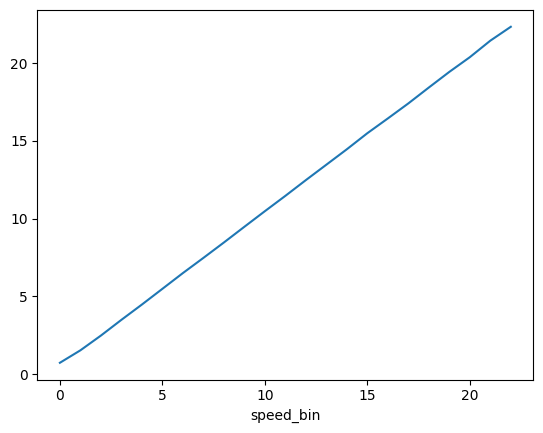

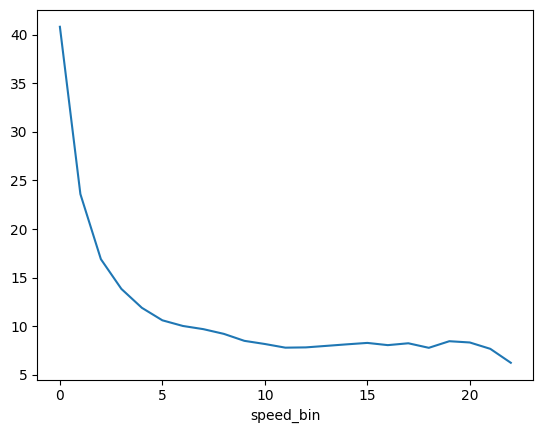

In [10]:
SpeedBinProps=WindData.groupby('speed_bin').mean()
SpeedBinProps['ws62'].plot()
plt.show()

SpeedBinProps['TI'].plot()
plt.show()

Now we can look at how properties vary with wind direction bin. First the speed:

In [11]:
DirBinProps=WindData.groupby('dir_bin').mean()
DirBinProps

,ws62,stdev62,wd60,TI,speed_bin
dir_bin,,,,,
0,2.701331,0.392785,151.328954,18.575747,2.200570
1,6.222326,0.551584,33.119740,11.710745,5.733519
2,5.598764,0.507708,56.877727,12.565686,5.111075
3,3.453645,0.408914,89.757956,15.928480,2.966040
4,4.774150,0.434216,122.108462,12.816377,4.270686
5,6.952532,0.618760,153.416916,10.714632,6.458119
6,8.497093,0.813049,178.374937,11.238328,8.001986
7,5.667489,0.684435,209.376589,13.902226,5.167925
8,4.392195,0.572740,239.506103,15.127208,3.894799


Here we can see that bin 6 (the one around south) has the highest mean speed (8.50 m/s). Notice that the direction mean in bin 0 is completely wrong! Can you figure out why? 

I haven't yet figured out how to plot this as a polar plot (i.e. something like a wind rose). Here as a boring linear plot:
Can somebody help here (with a nice radial plot) please!!

<Axes: xlabel='dir_bin'>

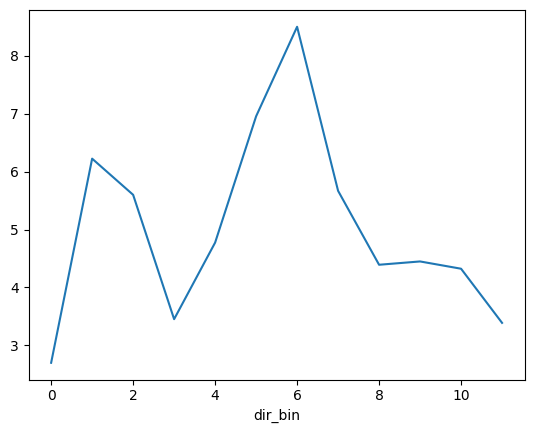

In [12]:
DirBinProps['ws62'].plot()

We can do the frequency by using the grouby('field').count():

In [13]:
DirBinCounts=WindData.groupby('dir_bin').count()
DirBinCounts

,ws62,stdev62,wd60,TI,speed_bin
dir_bin,,,,,
0,1052,1052,1052,1052,1052
1,3959,3959,3959,3959,3959
2,3106,3106,3106,3106,3106
3,1649,1649,1649,1649,1649
4,2405,2405,2405,2405,2405
5,7987,7987,7987,7987,7987
6,13094,13094,13094,13094,13094
7,7021,7021,7021,7021,7021
8,5076,5076,5076,5076,5076


Here we can see that the south sector (bin 6) is also the one where the wind blows most frequently.

In [7]:
WindData['hour']=WindData.index.hour
WindData

,ws62,stdev62,wd60,TI,hour
SCAN_NAME,,,,,
2011-01-01 00:00:00,3.65,0.18,255.43,4.931507,0
2011-01-01 00:10:00,3.79,0.15,260.83,3.957784,0
2011-01-01 00:20:00,3.74,0.17,260.23,4.545455,0
2011-01-01 00:30:00,3.25,0.21,269.83,6.461538,0
2011-01-01 00:40:00,3.03,0.25,271.83,8.250825,0
...,...,...,...,...,...
2011-12-31 23:10:00,6.26,0.70,165.93,11.182109,23
2011-12-31 23:20:00,6.39,0.59,165.63,9.233177,23
2011-12-31 23:30:00,6.79,0.61,167.43,8.983800,23


In [8]:
HourMeans=WindData.groupby('hour').mean()
HourMeans

,ws62,stdev62,wd60,TI
hour,,,,
0,4.980890,0.462324,177.818205,11.793862
1,4.725936,0.426014,170.569539,12.048151
2,4.698594,0.412169,165.247082,11.756416
3,4.683598,0.402119,159.957507,12.018767
4,4.543315,0.400712,158.593269,12.293082
5,4.494215,0.400114,158.973292,12.586052
6,4.353968,0.398119,148.863950,13.257302
7,4.279571,0.424648,145.184370,13.789564
8,4.263164,0.483575,147.415018,16.159933


<Axes: xlabel='hour'>

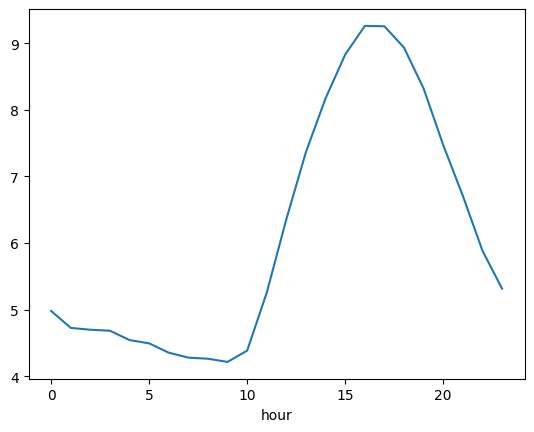

In [9]:
HourMeans['ws62'].plot()